# Training of an autoencoder using a subset of the images

In [1]:
import numpy as np
import scipy
import scipy.stats
import pandas as pd
import astropy.units as u
import sunpy.map
import sunpy.visualization.colormaps as cm
import cv2
import skimage
import skimage.filters
from skimage.filters import gaussian
from scipy import ndimage as ndi
import glob
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import scipy.ndimage
import numba
import random


import matplotlib.pyplot as plt
import seaborn as sns
import seaborn_image as isns
sns.set_style("darkgrid")

%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras import layers

import autoenc_model as aem
import data_generator as dg
import utils

2023-04-22 21:54:57.148362: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/eugeniolr/.local/lib/python3.10/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.8.0 and strictly below 2.11.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.12.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlo

In [2]:
noise_filter = True
apply_absmax = True
absmax_size = 4
gauss_sigma = 2

## Reading and normalizing the images

In [3]:
# Read images
file_list = glob.glob("data/hmi_magnetogram/2016*.fits")
print(len(file_list))

HMI_m_2016 = sunpy.map.Map(file_list)

HMI_m_2016_matrix = np.array(list(d.data for d in HMI_m_2016))

HMI_m_2016_mnorm = dg.HMImGenerator.normalize(HMI_m_2016_matrix)

input_train, input_test = train_test_split(HMI_m_2016_mnorm, test_size=0.25)

2908


/home/eugeniolr/Documents/master/TFM/data_generator.py:135: RuntimeWarning: All-NaN slice encountered
  max_values = np.nanmax(np.nanmax(np.abs(data_matrix), axis=2, keepdims=True), axis=1, keepdims=True)


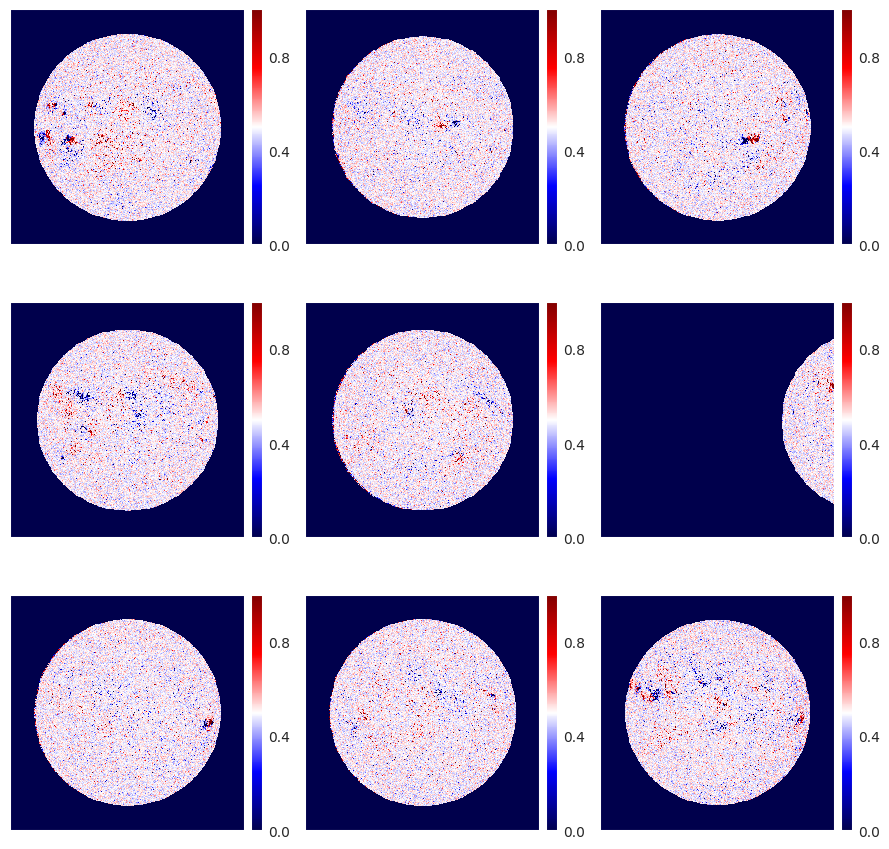

In [4]:
# aia193_colormap = cm.color_tables.aia_color_table(193*u.angstrom)
isns.ImageGrid([i for i in HMI_m_2016_mnorm[:9]], cmap="seismic", vmin=0, vmax=1)

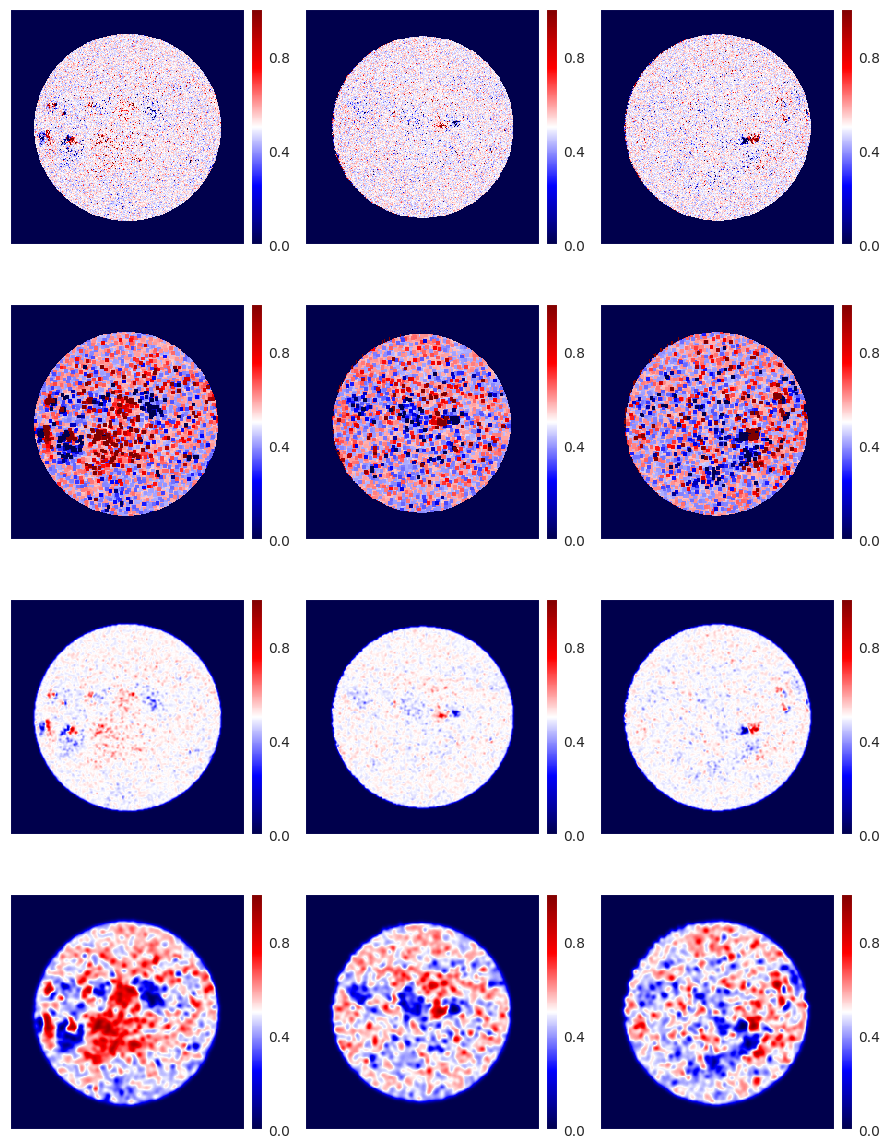

In [5]:
# base_filter = lambda x: gaussian(abs_max_filter(x, absmax_size), sigma=gauss_sigma)
repair_filter = lambda x: gaussian(utils.abs_max_filter(x - 0.5, absmax_size) + 0.5, gauss_sigma)

first_3_copy = np.copy(HMI_m_2016_mnorm[:3])
isns.ImageGrid(
    # ([i for i in first_3_copy]),
    [i for i in HMI_m_2016_mnorm[:3]],
    cmap="seismic",
    map_func=[lambda x: x, lambda x, **params: utils.abs_max_filter(x - 0.5, **params) + 0.5, gaussian, repair_filter],
    map_func_kw=[{}, {"kernel_size": absmax_size}, {}, {}],
    col_wrap=3,
    vmin=0,
    vmax=1
)

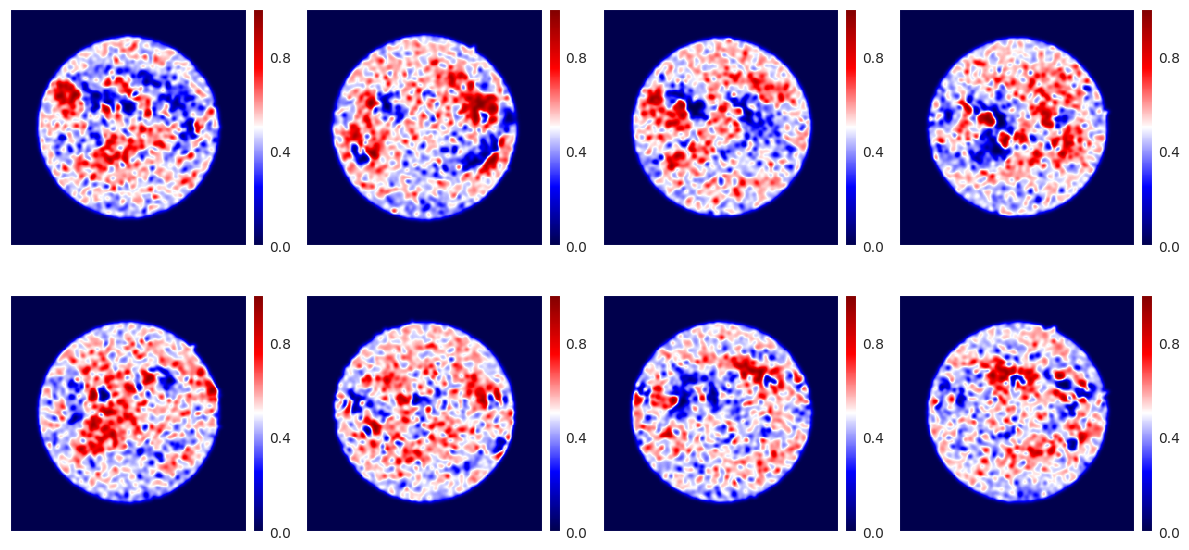

In [7]:
if apply_absmax:
    input_train = gaussian(utils.abs_max_filter_par(input_train - 0.5, absmax_size) + 0.5, sigma=gauss_sigma, channel_axis=0)
    input_test = gaussian(utils.abs_max_filter_par(input_test - 0.5, absmax_size) + 0.5, sigma=gauss_sigma, channel_axis=0)

    # input_train = skimage.restoration.denoise_tv_chambolle(input_train, channel_axis=0)
    # input_test = skimage.restoration.denoise_tv_chambolle(input_test, channel_axis=0)


isns.ImageGrid(random.sample(list(input_train), 4) + random.sample(list(input_test), 4), col_wrap=4, cmap="seismic",vmin=0, vmax=1)

## Training the model

In [20]:
latent_size = 128
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
# optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.5)
# optimizer = keras.optimizers.RMSprop(learning_rate=0.0001)

autoencoder, encoder, decoder = aem.gen_autoenc_model_1c(latent_size, optim=optimizer, loss="mse")

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d_33 (Conv2D)          (None, 256, 256, 8)       80        
                                                                 
 conv2d_34 (Conv2D)          (None, 256, 256, 8)       584       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 128, 128, 8)      0         
 2D)                                                             
                                                                 
 conv2d_35 (Conv2D)          (None, 128, 128, 16)      1168      
                                                                 
 conv2d_36 (Conv2D)          (None, 128, 128, 16)      2320      
                                                           

In [21]:
n_epochs = 125
batch_size = 128

# no_improve_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, min_delta=1e-5)

# history = autoencoder.fit(input_train, input_train, epochs=n_epochs, validation_split=0.1, batch_size=batch_size, callbacks=[no_improve_callback])
history = autoencoder.fit(input_train, input_train, epochs=n_epochs, validation_split=0.1, batch_size=batch_size)

Epoch 1/125
16/16 [==============================] - 2s 87ms/step - loss: 0.1209 - mae: 0.2314 - val_loss: 0.1187 - val_mae: 0.2309
Epoch 2/125
16/16 [==============================] - 1s 76ms/step - loss: 0.1166 - mae: 0.2303 - val_loss: 0.1095 - val_mae: 0.2275
Epoch 3/125
16/16 [==============================] - 1s 77ms/step - loss: 0.0901 - mae: 0.2158 - val_loss: 0.0565 - val_mae: 0.1941
Epoch 4/125
16/16 [==============================] - 1s 77ms/step - loss: 0.0493 - mae: 0.1826 - val_loss: 0.0377 - val_mae: 0.1609
Epoch 5/125
16/16 [==============================] - 1s 76ms/step - loss: 0.0335 - mae: 0.1524 - val_loss: 0.0290 - val_mae: 0.1409
Epoch 6/125
16/16 [==============================] - 1s 77ms/step - loss: 0.0273 - mae: 0.1368 - val_loss: 0.0249 - val_mae: 0.1293
Epoch 7/125
16/16 [==============================] - 1s 77ms/step - loss: 0.0242 - mae: 0.1268 - val_loss: 0.0223 - val_mae: 0.1204
Epoch 8/125
16/16 [==============================] - 1s 76ms/step - loss: 0.

## Evaluating the model

23/23 [==============================] - 0s 6ms/step - loss: 0.0058 - mae: 0.0398


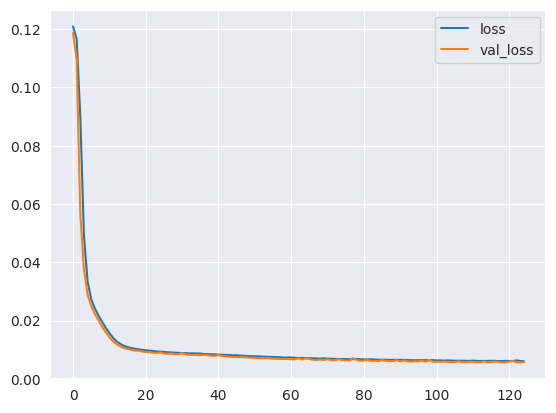

In [22]:
autoencoder.evaluate(input_test, input_test)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()
plt.show()

1/1 [==============================] - 0s 35ms/step


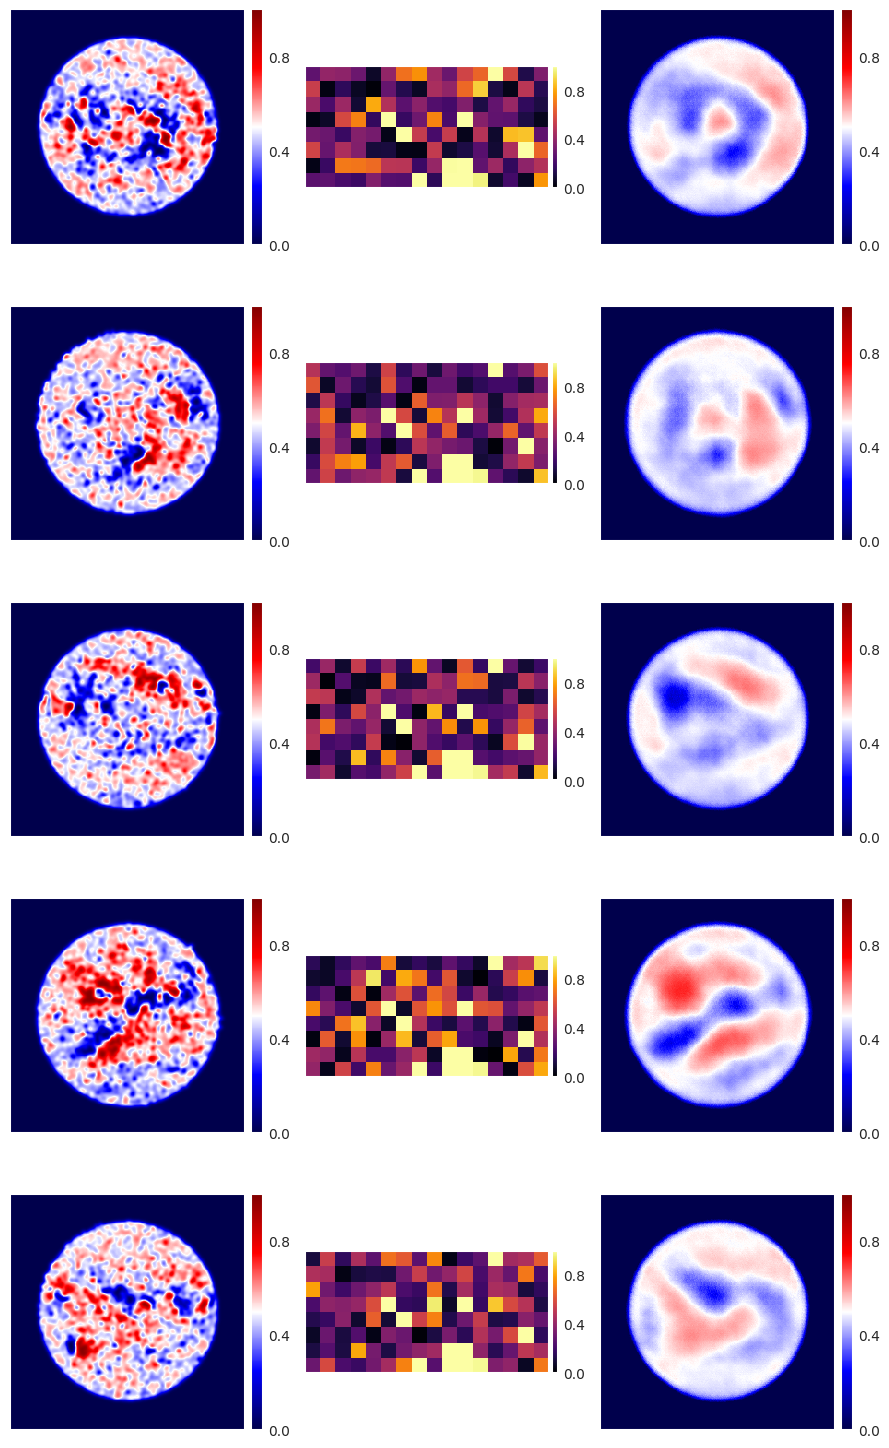

In [23]:
idx = np.random.permutation(80)[:5]

example = input_test[idx]
code = encoder.predict(example)
reconstructed = decoder(code)

images_zipped = [i for i in zip(example, code, reconstructed)]
images = []

for i in images_zipped:
    images.append(np.squeeze(i[0]))
    images.append(utils.square_dims_vector(i[1]))
    images.append(np.squeeze(i[2]))
    

isns.ImageGrid(images, cmap=["seismic", "inferno", "seismic"]*5, vmin=0, vmax=1, col_wrap=3)

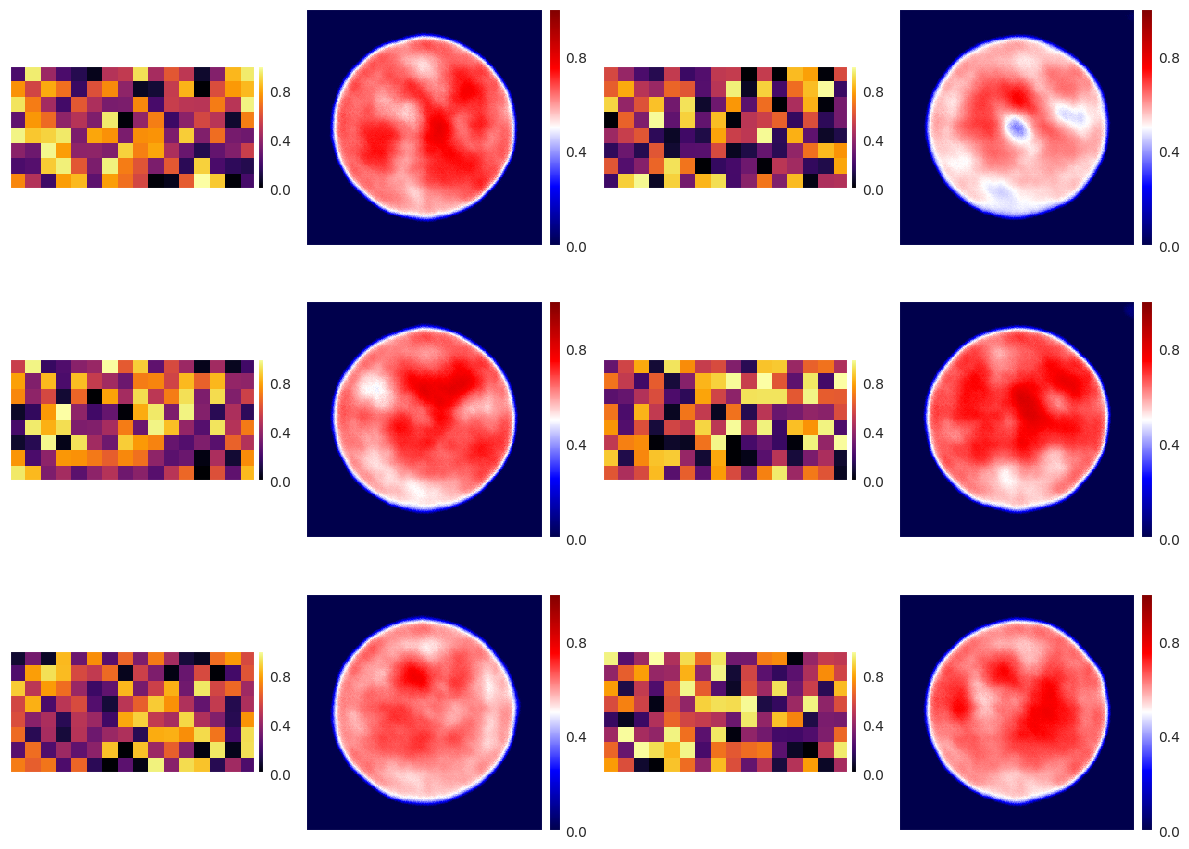

In [24]:
code = np.random.uniform(0, 1, [6, latent_size])
reconstructed = decoder(code)

images_zipped = [i for i in zip(code, reconstructed)]
images = []

for i in images_zipped:
    images.append(utils.square_dims_vector(i[0]))
    images.append(np.squeeze(i[1]))
    

isns.ImageGrid(images, cmap=["inferno", "seismic"]*6, vmin=0, vmax=1, col_wrap=4)